### ATMS 597 Project 6 Group D



<b> Set Working Directory </b>

In [1]:
#YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/ATMS597/project6/' # Sarah
# YOUR_DIRECTORY = '/content/drive/My Drive/Project6/' # Michael
YOUR_DIRECTORY = './' # David


<b> Import libraries</b>

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns; sns.set(font_scale = 1.5)

## Data Processing

<b> Import Data </b>

In [3]:
gfs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)

hourly_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
hourly_obs.index = hourly_obs.index + pd.DateOffset(hours=12)

daily_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
daily_obs.index = daily_obs.index + pd.DateOffset(hours=12)

gfs_sfc = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Sfc_06Zto06ZAvgMinMax_AdditionalVars_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
gfs_sfc.index = gfs_sfc.index + pd.DateOffset(days=1)

gfs_prof = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Prof_06Zto06ZAvgMinMax_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
gfs_prof.index = gfs_prof.index + pd.DateOffset(days=1)

<b> Merge Datasets </b>

In [4]:
features = pd.merge(daily_obs.reset_index(), gfs.reset_index(), on = 'Date', how = 'inner')
features = pd.merge(features, hourly_obs.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')
features = pd.merge(features, gfs_sfc.reset_index(), how = 'inner', left_on = 'Date', right_on = 'index').drop(columns = 'index')
features = pd.merge(features, gfs_prof.reset_index(), how = 'inner', left_on = 'Date', right_on = 'index').drop(columns = 'index')
features.dropna(inplace = True)  # There are some NaNs in the observations

<b> Other stuff </b>

In [5]:
# Add year, month, day as integers
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['day'] = features['Date'].dt.day

# Filter the predictors
predictors = features.drop(columns = ['Date', 'Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)

# For plotting
test_dates = np.array(features.query('year == 2019')['Date'])

<b> Split </b>

In [6]:
# Tmax
train_verification_tmax = np.array(features.query('year < 2019')['Max Hourly Temp (C)'])
test_verification_tmax = np.array(features.query('year == 2019')['Max Hourly Temp (C)'])

rf_tmax_vars  = ['TMAX','TMIN','tmpc','dwpc','WMAX','day','Avg DWPDEP(C)','Max DWPDEP(C)','Avg LCLD(%)','Avg HCLD(%)','Avg PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa TMPC',
                      'Min 925hPa TMPC','Max 925hPa TMPC','Min 250hPa WSPD(m/s)','Min 850hPa WSPD(m/s)']

rf_train_vars_tmax = predictors.query('year < 2019')[rf_tmax_vars] 
rf_test_vars_tmax = predictors.query('year == 2019')[rf_tmax_vars]

# Tmin 
train_verification_tmin = np.array(features.query('year < 2019')['Min Hourly Temp (C)'])
test_verification_tmin = np.array(features.query('year == 2019')['Min Hourly Temp (C)'])

rf_tmin_vars = ['TMAX','TMIN','WMAX','RTOT','mslp','wspd','skct','tmpc','dwpc','pr1h','Avg DWPDEP(C)','Avg LCLD(%)','Max LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Max HCLD(%)',
                     'Avg PRES(hPa)','Max PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)','Avg 250hPa HGT(m)','Avg 500hPa HGT(m)','Min 850hPa TMPC','Min 925hPa TMPC',
                     'Min 250hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 925hPa WSPD(m/s)'] 

rf_train_vars_tmin = predictors.query('year < 2019')[rf_tmin_vars] 
rf_test_vars_tmin = predictors.query('year == 2019')[rf_tmin_vars]

# Wind
train_verification_wind = np.array(features.query('year < 2019')['Max Wind Speed (m/s)'])
test_verification_wind = np.array(features.query('year == 2019')['Max Wind Speed (m/s)'])

rf_train_vars_wind = predictors.query('year < 2019').to_numpy()  # Use all available predictors
rf_test_vars_wind = predictors.query('year == 2019').to_numpy()

# Precip
train_verification_prcp = np.array(features.query('year < 2019')['Daily Precip (mm)'])
test_verification_prcp = np.array(features.query('year == 2019')['Daily Precip (mm)'])

rf_prcp_vars = ['RTOT','TMAX','TMIN','WMAX','tmpc','mslp','skct','day','Min MCLD(%)','Max MCLD(%)','Max HCLD(%)','Avg PRES(hPa)','Min 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)',
                            'Avg 500hPa HGT(m)','Max 500hPa WSPD(m/s)','Max 925hPa WSPD(m/s)','Avg 850hPa WSPD(m/s)','Avg 500hPa WSPD(m/s)','Avg 250hPa DWPDEP(C)',
                            'Avg 500hPa DWPDEP(C)','Min 500hPa DWPDEP(C)','Avg 700hPa DWPDEP(C)','Min 700hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)']

rf_train_vars_prcp = predictors.query('year < 2019')[rf_prcp_vars] 
rf_test_vars_prcp = predictors.query('year == 2019')[rf_prcp_vars]

# Random Forest Regression

## Maximum Temperature

### Training Model

In [17]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfmax = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfmax.fit(rf_train_vars_tmax, train_verification_tmax);

### RMSE

In [17]:
rf_predictions_tmax = rfmax.predict(rf_test_vars_tmax)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmax, rf_predictions_tmax, squared = False), 2), 'degrees C.')

Root Mean Square Error: 1.92 degrees C.


### Plot

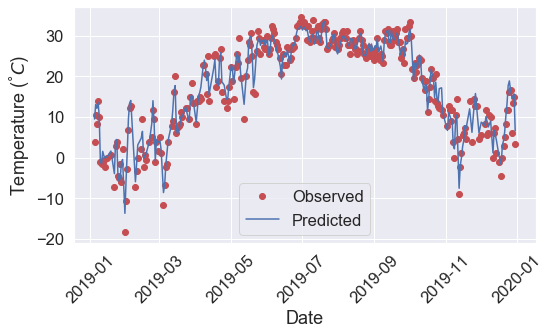

In [18]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmax, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_tmax, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Minimum Temperature

### Training Model

In [19]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfmin = rfmin = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfmin.fit(rf_train_vars_tmin, train_verification_tmin);

### RMSE

In [20]:
rf_predictions_tmin = rfmin.predict(rf_test_vars_tmin)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmin, rf_predictions_tmin, squared = False), 2), 'degrees C.')

Root Mean Square Error: 2.11 degrees C.


### Plot

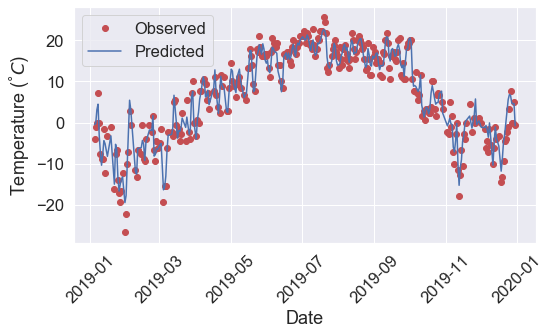

In [21]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmin, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_tmin, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Maximum Wind

### Training Model

In [22]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfwind = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfwind.fit(rf_train_vars_wind, train_verification_wind);

### RMSE

In [23]:
rf_predictions_wind = rfwind.predict(rf_test_vars_wind)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_wind, rf_predictions_wind, squared = False), 2), 'm/s.')

Root Mean Square Error: 1.69 m/s.


### Plot

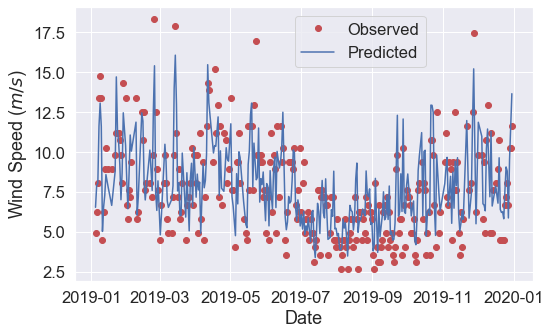

In [24]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_wind, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_wind, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed ($m/s$)')
plt.legend(loc = [0.48, 0.78])
plt.tight_layout()
plt.show()

## Precipitation

### Training Model

In [25]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfprcp = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 8, min_samples_split = 3, bootstrap = True)
rfprcp.fit(rf_train_vars_prcp, train_verification_prcp);

### RMSE

In [26]:
rf_predictions_prcp = rfprcp.predict(rf_test_vars_prcp)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_prcp, rf_predictions_prcp, squared = False), 2), 'mm.')

Root Mean Square Error: 4.18 mm.


### Plot

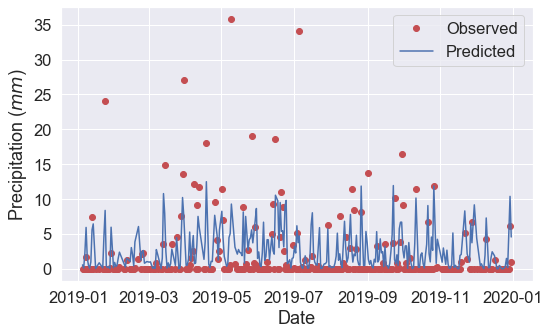

In [27]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_prcp, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_prcp, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation ($mm$)')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

# Neural Network

<b> Import libraries </b>

In [7]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from sklearn import preprocessing

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import IPython

import datetime, os
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

print(tf.__version__)

2.0.0


## Maximum Temperature

In [8]:
rf_train_vars_tmax.head()

,TMAX,TMIN,tmpc,dwpc,WMAX,day,Avg DWPDEP(C),Max DWPDEP(C),Avg LCLD(%),Avg HCLD(%),Avg PRES(hPa),Avg 850hPa DWPDEP(C),Max 850hPa TMPC,Min 925hPa TMPC,Max 925hPa TMPC,Min 250hPa WSPD(m/s),Min 850hPa WSPD(m/s)
0,-10.16,-15.96,-13.325000,-16.933333,4.687217,2,3.530000,4.95,36.000000,0.000000,1000.722222,15.539375,-14.439245,-19.584138,-15.991250,73.887425,13.817925
1,-9.96,-14.36,-16.525000,-19.816667,5.941380,3,3.194444,4.43,3.555556,7.375000,1000.677778,19.689315,-11.294434,-15.187083,-12.670853,28.958127,9.187170
2,-8.46,-12.86,-15.325000,-19.858333,5.685068,4,2.160000,3.11,37.777778,40.222222,998.111111,11.441479,-11.160000,-14.453023,-11.653750,11.908539,16.236038
3,-7.16,-11.06,-14.441667,-17.700000,3.794733,5,1.876667,2.37,96.555556,26.777778,996.388889,10.031624,-8.604550,-12.781705,-10.715814,9.865169,18.732500
4,-5.46,-7.46,-15.133333,-18.383333,9.548298,6,1.624444,2.39,77.125000,36.666667,994.244444,14.460429,-6.668571,-10.843721,-9.252248,46.999925,5.498429


In [9]:
# Standardize
rf_train_vars_tmax_norm = preprocessing.scale(rf_train_vars_tmax)

In [10]:
rf_train_vars_tmax_norm

array([[-2.32891796, -2.30849916, -2.27732287, ..., -2.76554373,
         1.07224601,  0.20569136],
       [-2.31115791, -2.14857422, -2.54522292, ..., -2.44072711,
        -0.60705908, -0.36187575],
       [-2.17795748, -1.9986446 , -2.4447604 , ..., -2.34122941,
        -1.24431497,  0.50206671],
       ...,
       [-0.23323133, -0.20948443, -0.73271164, ..., -0.54641769,
         1.19174789, -1.06252997],
       [-0.43747197, -0.70924984, -0.9141023 , ..., -0.10771683,
         0.90899938,  2.73577866],
       [-1.27219462, -0.97912316, -0.48295066, ..., -0.23558141,
         1.94153544,  0.83527197]])

### Build Model

In [11]:
# Build Model with 1 hidden layer of 20 neurons
def build_model():
    model = keras.Sequential([
      Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmax_norm[0])]),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model 

### Train Model

In [12]:
%%time
model = build_model()

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(rf_train_vars_tmax_norm, train_verification_tmax, epochs=1000, validation_split = 0.1, callbacks=[tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/1000
2631/2631 [==============================] - 2s 789us/sample - loss: 417.2899 - mae: 17.8363 - mse: 417.2899 - val_loss: 400.7869 - val_mae: 17.7167 - val_mse: 400.7869
Epoch 2/1000
2631/2631 [==============================] - 0s 142us/sample - loss: 328.2991 - mae: 16.0010 - mse: 328.2991 - val_loss: 285.0662 - val_mae: 15.1733 - val_mse: 285.0662
Epoch 3/1000
2631/2631 [==============================] - 0s 185us/sample - loss: 221.0301 - mae: 13.3239 - mse: 221.0301 - val_loss: 159.1391 - val_mae: 11.5471 - val_mse: 159.1391
Epoch 4/1000
2631/2631 [==============================] - 1s 216us/sample - loss: 124.8518 - mae: 9.9864 - mse: 124.8518 - val_loss: 78.5528 - val_mae: 7.7441 - val_mse: 78.5528
Epoch 5/1000
2631/2631 [==============================] - 1s 191us/sample - loss: 76.0105 - mae: 7.3579 - mse: 76.0105 - val_loss: 54.0834 - val_mae: 6.1367 - val_mse: 54.0834
Epoch 6/1000
2631/2631 [=============================

### RMSE

In [13]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

Final Root Mean Square Error on validation set: 2.077


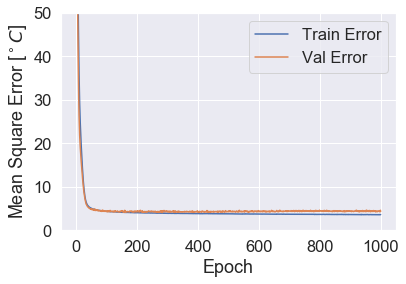

In [23]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$^\circ C$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,50])

plot_history()

In [20]:
rf_test_vars_tmax_norm = preprocessing.scale(rf_test_vars_tmax)
mse, _, _ = model.evaluate(rf_test_vars_tmax_norm, test_verification_tmax)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

307/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================